In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [8]:
data_dir = '~/Documents/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [11]:
data = pd.read_csv(fname)

In [12]:
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


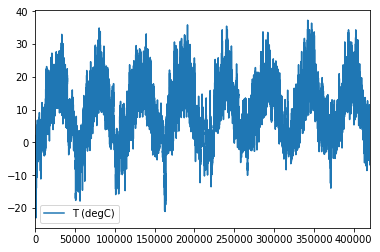

In [17]:
data.plot(y='T (degC)')
plt.show()

In [18]:
data.index = pd.to_datetime(data['Date Time'])

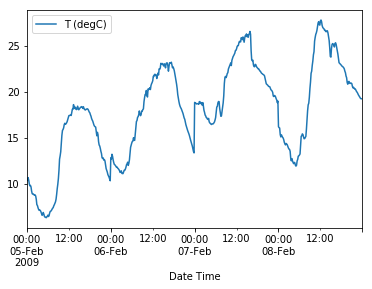

In [31]:
data['2009/02/05':'2009/02/08'].plot(y='T (degC)')
plt.show()

## Standardization

In [36]:
float_data = data.as_matrix(columns=['p (mbar)','T (degC)','Tpot (K)','Tdew (degC)','rh (%)','VPmax (mbar)','VPact (mbar)','VPdef (mbar)','sh (g/kg)','H2OC (mmol/mol)','rho (g/m**3)','wv (m/s)','max. wv (m/s)','wd (deg)'] )

In [37]:
float_data.shape

(420551, 14)

In [38]:
float_data[:1]

array([[  9.96520000e+02,  -8.02000000e+00,   2.65400000e+02,
         -8.90000000e+00,   9.33000000e+01,   3.33000000e+00,
          3.11000000e+00,   2.20000000e-01,   1.94000000e+00,
          3.12000000e+00,   1.30775000e+03,   1.03000000e+00,
          1.75000000e+00,   1.52300000e+02]])

In [39]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

In [40]:
std = float_data[:200000].std(axis=0)
float_data /= std

## Data generator

In [52]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback,
                                    max_index,
                                    size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets =np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [53]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [43]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size
# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [44]:
val_steps

769

In [45]:
test_steps

930

## Baseline prediction

In [54]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.289735972991


## Gated Recurent Unit predictions

In [55]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [58]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [61]:
model.compile(optimizer=RMSprop(),
             loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 99s - loss: 0.3032 - val_loss: 0.2757
Epoch 2/20
500/500 [==============================] - 98s - loss: 0.2856 - val_loss: 0.2657
Epoch 3/20
500/500 [==============================] - 99s - loss: 0.2794 - val_loss: 0.2659
Epoch 4/20
500/500 [==============================] - 98s - loss: 0.2733 - val_loss: 0.2634
Epoch 5/20
500/500 [==============================] - 99s - loss: 0.2691 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 99s - loss: 0.2625 - val_loss: 0.2677
Epoch 7/20
500/500 [==============================] - 98s - loss: 0.2573 - val_loss: 0.2627
Epoch 8/20
500/500 [==============================] - 98s - loss: 0.2539 - val_loss: 0.2708
Epoch 9/20
500/500 [==============================] - 98s - loss: 0.2485 - val_loss: 0.2715
Epoch 10/20
500/500 [==============================] - 97s - loss: 0.2455 - val_loss: 0.2779
Epoch 11/20
500/500 [==============================] - 97s - loss: 0.2400 - val

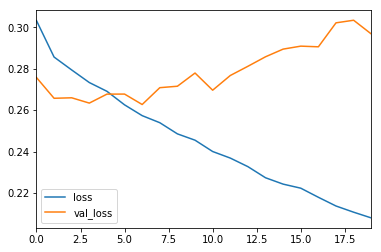

In [64]:
pd.DataFrame(history.history).plot()
plt.show()

## Add dropout

In [66]:
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [67]:
model.compile(optimizer=RMSprop(),
             loss='mae')

In [69]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 100s - loss: 0.3376 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 100s - loss: 0.3167 - val_loss: 0.2716
Epoch 3/40
500/500 [==============================] - 101s - loss: 0.3109 - val_loss: 0.2706
Epoch 4/40
500/500 [==============================] - 101s - loss: 0.3051 - val_loss: 0.2711
Epoch 5/40
500/500 [==============================] - 100s - loss: 0.3026 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 101s - loss: 0.2991 - val_loss: 0.2753
Epoch 7/40
500/500 [==============================] - 101s - loss: 0.2957 - val_loss: 0.2712
Epoch 8/40
500/500 [==============================] - 100s - loss: 0.2933 - val_loss: 0.2669
Epoch 9/40
500/500 [==============================] - 101s - loss: 0.2925 - val_loss: 0.2683
Epoch 10/40
500/500 [==============================] - 100s - loss: 0.2919 - val_loss: 0.2653
Epoch 11/40
500/500 [==============================] - 101s - loss: 0

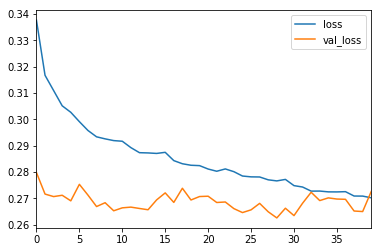

In [70]:
pd.DataFrame(history.history).plot()
plt.show()

In [71]:
model = Sequential()
model.add(layers.GRU(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae')

In [72]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=30,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/30
500/500 [==============================] - 101s - loss: 0.3302 - val_loss: 0.2758
Epoch 2/30
500/500 [==============================] - 101s - loss: 0.3098 - val_loss: 0.2695
Epoch 3/30
500/500 [==============================] - 101s - loss: 0.3031 - val_loss: 0.2811
Epoch 4/30
500/500 [==============================] - 101s - loss: 0.2966 - val_loss: 0.2698
Epoch 5/30
500/500 [==============================] - 101s - loss: 0.2914 - val_loss: 0.2650
Epoch 6/30
500/500 [==============================] - 101s - loss: 0.2904 - val_loss: 0.2644
Epoch 7/30
500/500 [==============================] - 101s - loss: 0.2858 - val_loss: 0.2677
Epoch 8/30
500/500 [==============================] - 101s - loss: 0.2841 - val_loss: 0.2629
Epoch 9/30
500/500 [==============================] - 101s - loss: 0.2817 - val_loss: 0.2631
Epoch 10/30
500/500 [==============================] - 101s - loss: 0.2786 - val_loss: 0.2645
Epoch 11/30
500/500 [==============================] - 102s - loss: 0

## Use LSTM

In [73]:
model = Sequential()
model.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae')

In [74]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 125s - loss: 0.3350 - val_loss: 0.2764
Epoch 2/20
500/500 [==============================] - 124s - loss: 0.3050 - val_loss: 0.2706
Epoch 3/20
500/500 [==============================] - 125s - loss: 0.2990 - val_loss: 0.2664
Epoch 4/20
500/500 [==============================] - 124s - loss: 0.2947 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 124s - loss: 0.2907 - val_loss: 0.2696
Epoch 6/20
500/500 [==============================] - 124s - loss: 0.2887 - val_loss: 0.2654
Epoch 7/20
500/500 [==============================] - 125s - loss: 0.2869 - val_loss: 0.2692
Epoch 8/20
500/500 [==============================] - 124s - loss: 0.2832 - val_loss: 0.2663
Epoch 9/20
500/500 [==============================] - 125s - loss: 0.2811 - val_loss: 0.2683
Epoch 10/20
500/500 [==============================] - 124s - loss: 0.2782 - val_loss: 0.2696
Epoch 11/20
500/500 [==============================] - 125s - loss: 0

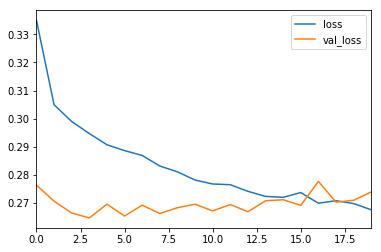

In [75]:
pd.DataFrame(history.history).plot()
plt.show()

In [76]:
model = Sequential()
model.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(lr=1e-4),
             loss='mae')

In [77]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=10,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 125s - loss: 0.4462 - val_loss: 0.3088
Epoch 2/10
500/500 [==============================] - 124s - loss: 0.3503 - val_loss: 0.2902
Epoch 3/10
500/500 [==============================] - 124s - loss: 0.3358 - val_loss: 0.2846
Epoch 4/10
500/500 [==============================] - 125s - loss: 0.3267 - val_loss: 0.2818
Epoch 5/10
500/500 [==============================] - 124s - loss: 0.3231 - val_loss: 0.2802
Epoch 6/10
500/500 [==============================] - 124s - loss: 0.3173 - val_loss: 0.2793
Epoch 7/10
500/500 [==============================] - 125s - loss: 0.3153 - val_loss: 0.2779
Epoch 8/10
500/500 [==============================] - 124s - loss: 0.3132 - val_loss: 0.2754
Epoch 9/10
500/500 [==============================] - 124s - loss: 0.3124 - val_loss: 0.2754
Epoch 10/10
500/500 [==============================] - 125s - loss: 0.3099 - val_loss: 0.2737


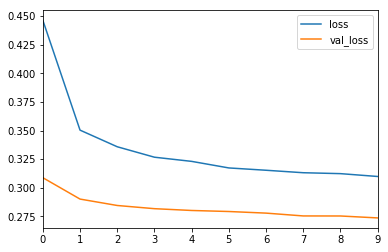

In [78]:
pd.DataFrame(history.history).plot()
plt.show()

In [84]:
model = Sequential()
model.add(layers.GRU(64,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, activation='relu',
                    dropout=0.1,
                    return_sequences=True,
                    recurrent_dropout=0.5))
model.add(layers.GRU(16, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(lr=1e-4),
             loss='mae')

In [85]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=30,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/30
500/500 [==============================] - 294s - loss: 0.4430 - val_loss: 0.3105
Epoch 2/30
500/500 [==============================] - 293s - loss: 0.3632 - val_loss: 0.2951
Epoch 3/30
500/500 [==============================] - 293s - loss: 0.3492 - val_loss: 0.2924
Epoch 4/30
500/500 [==============================] - 292s - loss: 0.3377 - val_loss: 0.2899
Epoch 5/30
500/500 [==============================] - 293s - loss: 0.3341 - val_loss: 0.2865
Epoch 6/30
500/500 [==============================] - 293s - loss: 0.3280 - val_loss: 0.2813
Epoch 7/30
500/500 [==============================] - 293s - loss: 0.3245 - val_loss: 0.2844
Epoch 8/30
500/500 [==============================] - 293s - loss: 0.3219 - val_loss: 0.2834
Epoch 9/30
500/500 [==============================] - 293s - loss: 0.3171 - val_loss: 0.2789
Epoch 10/30
500/500 [==============================] - 293s - loss: 0.3164 - val_loss: 0.2776
Epoch 11/30
500/500 [==============================] - 293s - loss: 0

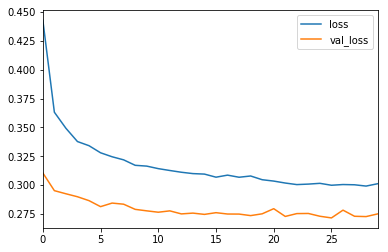

In [86]:
pd.DataFrame(history.history).plot()
plt.show()